In [2]:
import pandas as pd

df = pd.read_csv('cleaned_data.csv', index_col=0)

df.head()

,State,County,City,datetime,Humidity,Temperature,Pressure,Wind_speed,Wind_direction,Weather_description,NO2 Mean,NO2 AQI,O3 Mean,O3 AQI,SO2 Mean,SO2 AQI,CO Mean,CO AQI
0,New Mexico,Bernalillo,Albuquerque,2012-10-01,48.909091,12.326208,1024.000000,4.000000,360.000000,sky is clear,10.441667,21.0,0.037792,43.0,0.483334,0.0,0.107396,2.0
1,New Mexico,Bernalillo,Albuquerque,2012-10-02,40.363636,16.621821,1022.772727,3.166667,303.458333,sky is clear,10.416667,29.0,0.029458,41.0,0.556250,0.0,0.137020,2.0
2,New Mexico,Bernalillo,Albuquerque,2012-10-03,31.904762,18.055417,1021.666667,2.958333,132.708333,few clouds,17.575000,40.0,0.022042,32.0,0.875000,4.0,0.248854,5.0
3,New Mexico,Bernalillo,Albuquerque,2012-10-04,19.681818,19.946250,1018.318182,1.916667,144.541667,few clouds,18.612500,46.0,0.036542,44.0,0.835417,3.0,0.208396,3.0
4,New Mexico,Bernalillo,Albuquerque,2012-10-05,18.250000,19.679167,1020.850000,2.583333,225.875000,scattered clouds,12.504167,25.0,0.037125,39.0,0.641666,0.0,0.121688,2.0


In [3]:
len(df)

17184

In [4]:
# feature correlation
import seaborn as sns
import matplotlib.pyplot as plt

corr = df.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

ValueError: could not convert string to float: 'New Mexico'

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Load the dataset
data = pd.read_csv('cleaned_data.csv', index_col=0)

# Preprocessing
# Convert 'datetime' to datetime object and extract year, month, day
data['datetime'] = pd.to_datetime(data['datetime'])
data['year'] = data['datetime'].dt.year
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day
data = data.drop(columns=['datetime'])

# Handling categorical data - Encoding 'State', 'County', 'City', 'Weather_description'
categorical_features = ['State', 'County', 'City', 'Weather_description']
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_features.remove('NO2 AQI')  # Target variable

# Impute missing values in numerical columns
numerical_imputer = SimpleImputer(strategy='mean')
data[numerical_features] = numerical_imputer.fit_transform(data[numerical_features])

# If there are any remaining missing values, drop those rows
data = data.dropna()

data.head()

,State,County,City,Humidity,Temperature,Pressure,Wind_speed,Wind_direction,Weather_description,NO2 Mean,NO2 AQI,O3 Mean,O3 AQI,SO2 Mean,SO2 AQI,CO Mean,CO AQI,year,month,day
0,New Mexico,Bernalillo,Albuquerque,48.909091,12.326208,1024.000000,4.000000,360.000000,sky is clear,10.441667,21.0,0.037792,43.0,0.483334,0.0,0.107396,2.0,2012,10,1
1,New Mexico,Bernalillo,Albuquerque,40.363636,16.621821,1022.772727,3.166667,303.458333,sky is clear,10.416667,29.0,0.029458,41.0,0.556250,0.0,0.137020,2.0,2012,10,2
2,New Mexico,Bernalillo,Albuquerque,31.904762,18.055417,1021.666667,2.958333,132.708333,few clouds,17.575000,40.0,0.022042,32.0,0.875000,4.0,0.248854,5.0,2012,10,3
3,New Mexico,Bernalillo,Albuquerque,19.681818,19.946250,1018.318182,1.916667,144.541667,few clouds,18.612500,46.0,0.036542,44.0,0.835417,3.0,0.208396,3.0,2012,10,4
4,New Mexico,Bernalillo,Albuquerque,18.250000,19.679167,1020.850000,2.583333,225.875000,scattered clouds,12.504167,25.0,0.037125,39.0,0.641666,0.0,0.121688,2.0,2012,10,5


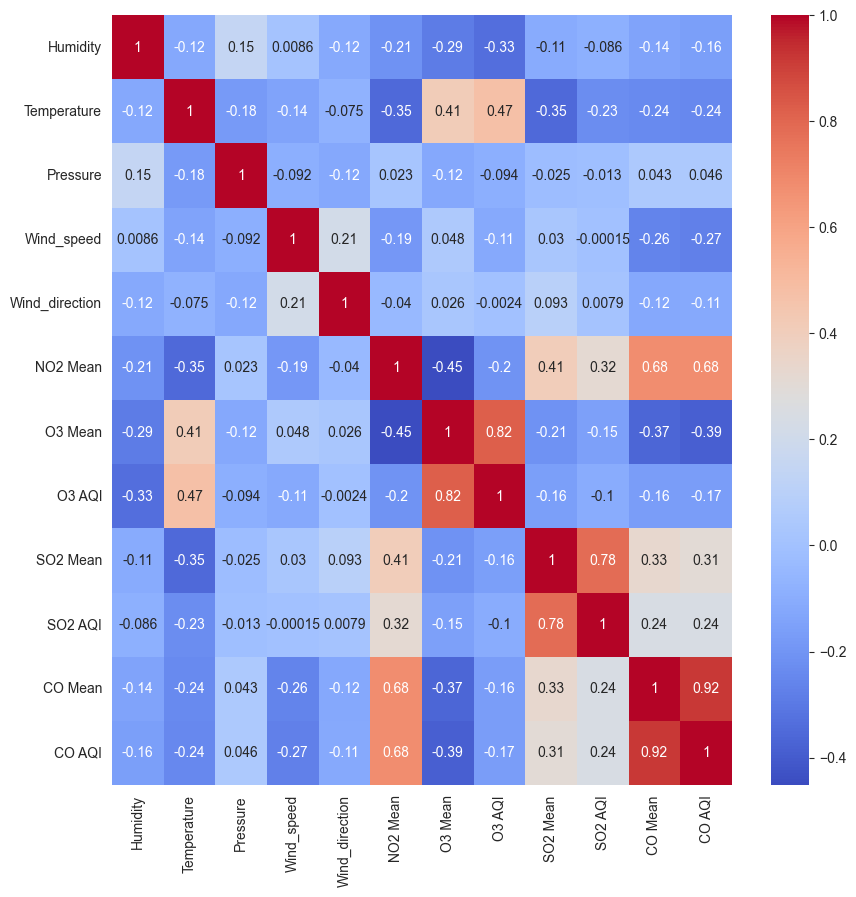

In [10]:
# Heatmap of correlation between features with only features
corr = data[numerical_features].corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [7]:
# Preprocessor for pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Splitting the data into features and target
X = data.drop('NO2 AQI', axis=1)
y = data['NO2 AQI']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Creating a pipeline with preprocessing and linear regression model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', LinearRegression())])

# Training the model
model.fit(X_train, y_train)

# Predicting and evaluating the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Root Mean Squared Error: {rmse}')

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f'Mean Absolute Percentage Error: {mape}')

# R-squared
r2 = model.score(X_test, y_test)
print(f'R-squared: {r2}')

Root Mean Squared Error: 5.175794517854003
Mean Absolute Percentage Error: 20.376308771862753
R-squared: 0.8274995803824934


In [8]:
df.describe()

,Humidity,Temperature,Pressure,Wind_speed,Wind_direction,NO2 Mean,NO2 AQI,O3 Mean,O3 AQI,SO2 Mean,SO2 AQI,CO Mean,CO AQI
count,17177.000000,17184.000000,17180.000000,17184.000000,17184.000000,17184.000000,17184.000000,17184.000000,17184.000000,17184.000000,17184.000000,17184.000000,17176.000000
mean,64.451233,13.426089,1018.709393,2.561234,177.927943,14.276068,25.926187,0.023871,33.612179,0.951692,3.177796,0.309596,5.010824
std,18.745091,9.521558,13.203596,1.560196,69.035931,8.247995,12.730394,0.010163,15.885912,1.129709,5.865459,0.171391,3.421962
min,5.000000,-19.157562,820.333333,0.000000,0.000000,0.062500,0.000000,0.000000,0.000000,-1.725155,0.000000,-0.047917,0.000000
25%,52.833333,6.481945,1013.500000,1.375000,129.583333,8.083333,16.000000,0.016417,24.000000,0.246280,0.000000,0.201143,3.000000
50%,66.958333,13.949813,1018.958333,2.291667,180.250000,12.507263,25.000000,0.023458,31.000000,0.662306,1.000000,0.263274,4.000000
75%,78.260870,20.809413,1025.250000,3.333333,227.041667,18.727746,34.000000,0.030878,41.000000,1.256250,4.000000,0.362368,6.000000
max,100.000000,38.664625,1084.250000,12.375000,360.000000,79.478261,108.000000,0.061542,182.000000,13.197916,108.000000,1.747917,50.000000


In [11]:
from sklearn.ensemble import RandomForestRegressor

# Creating a new pipeline with the adjusted preprocessor and Random Forest Regressor
rfr_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', RandomForestRegressor(n_estimators=100, random_state=0))])

# Training the Random Forest model
rfr_model.fit(X_train, y_train)

# Predicting and evaluating the Random Forest model
y_pred_rfr = rfr_model.predict(X_test)
mse_rfr = mean_squared_error(y_test, y_pred_rfr)
rmse_rfr = np.sqrt(mse_rfr)
print(f'Root Mean Squared Error: {rmse_rfr}')

# Mean Absolute Percentage Error (MAPE)
mape_rfr = np.mean(np.abs((y_test - y_pred_rfr) / y_test)) * 100
print(f'Mean Absolute Percentage Error: {mape_rfr}')

# R-squared
r2_rfr = rfr_model.score(X_test, y_test)
print(f'R-squared: {r2_rfr}')

Root Mean Squared Error: 4.734217681814442
Mean Absolute Percentage Error: 16.762183037633093
R-squared: 0.8556779963492114


In [12]:
# Formatting on AQI
data['AQI T1'] = data[['NO2 AQI', 'O3 AQI', 'SO2 AQI', 'CO AQI']].max(axis=1)
data['AQI T2'] = data[['NO2 AQI', 'O3 AQI', 'SO2 AQI', 'CO AQI']].mean(axis=1)

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Selecting only weather-related features and the target variable
features = ['Humidity', 'Temperature', 'Pressure', 'Wind_speed', 'Wind_direction']
targets = ['NO2 AQI', 'O3 AQI', 'SO2 AQI', 'CO AQI']
# nitrogen dioxide (NO2), ozone (O3), sulfur dioxide (SO2), and carbon monoxide (CO)

# Creating a general AQI metric as the mean of the individual AQIs
data['General AQI'] = data[targets].mean(axis=1)

# Preparing the feature and target datasets
X = data[features]
y = data['General AQI']

# Encoding categorical variables and scaling numerical variables
numerical_features = ['Humidity', 'Temperature', 'Pressure', 'Wind_speed', 'Wind_direction']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
    ])

# Creating a pipeline with preprocessing and the model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training the model
model.fit(X_train, y_train)

# Predicting on the test set
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse, mae, r2

(20.761823901393893, 3.3846338422901097, 0.34841768377246163)

In [32]:
from sklearn.model_selection import GridSearchCV

# Defining the parameters grid
param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20, 30],
}


# Initialize GridSearchCV using the pipeline, the parameters grid and a scoring method
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')

# Fit the Grid Search to the data
grid_search.fit(X_train, y_train)

# Use the best model to predict
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate and print the metrics again
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse, mae, r2

(20.67617625271602, 3.387480655286385, 0.3511056216708861)

In [34]:
import pickle

# Save to file in the current working directory
pkl_filename = "best_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(best_model, file)

In [35]:
# Range of AQI values
data['General AQI'].min(), data['General AQI'].max()


# percentage of AGI range for mse
mse / (data['General AQI'].max() - data['General AQI'].min())

0.374229434438299

In [23]:
data.head()

,State,County,City,Humidity,Temperature,Pressure,Wind_speed,Wind_direction,Weather_description,NO2 Mean,...,SO2 Mean,SO2 AQI,CO Mean,CO AQI,year,month,day,AQI T1,AQI T2,General AQI
0,New Mexico,Bernalillo,Albuquerque,48.909091,12.326208,1024.000000,4.000000,360.000000,sky is clear,10.441667,...,0.483334,0.0,0.107396,2.0,2012,10,1,43.0,16.50,16.50
1,New Mexico,Bernalillo,Albuquerque,40.363636,16.621821,1022.772727,3.166667,303.458333,sky is clear,10.416667,...,0.556250,0.0,0.137020,2.0,2012,10,2,41.0,18.00,18.00
2,New Mexico,Bernalillo,Albuquerque,31.904762,18.055417,1021.666667,2.958333,132.708333,few clouds,17.575000,...,0.875000,4.0,0.248854,5.0,2012,10,3,40.0,20.25,20.25
3,New Mexico,Bernalillo,Albuquerque,19.681818,19.946250,1018.318182,1.916667,144.541667,few clouds,18.612500,...,0.835417,3.0,0.208396,3.0,2012,10,4,46.0,24.00,24.00
4,New Mexico,Bernalillo,Albuquerque,18.250000,19.679167,1020.850000,2.583333,225.875000,scattered clouds,12.504167,...,0.641666,0.0,0.121688,2.0,2012,10,5,39.0,16.50,16.50


In [24]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
import datetime

# Update feature list
features = ['Humidity', 'Temperature', 'Pressure', 'Wind_speed', 'Wind_direction', 'Weather_description', 'year', 'month', 'day']
X = data[features]
y = data['General AQI']


# Update preprocessor with new features
numerical_features = ['Humidity', 'Temperature', 'Pressure', 'Wind_speed', 'Wind_direction', 'year', 'month', 'day']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown="ignore"), ['Weather_description'])
    ])

# Random Forest Hyperparameter Tuning
rf_params = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [10, 20, None],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2]
}

rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


rf_grid_search = GridSearchCV(rf_model, rf_params, cv=5, scoring='neg_mean_squared_error')
rf_grid_search.fit(X_train, y_train)

# Gradient Boosting and XGBoost Models
gb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(random_state=42))
])

# Cross-validation scores
rf_cv_score = cross_val_score(rf_grid_search.best_estimator_, X, y, cv=5, scoring='neg_mean_squared_error')
gb_cv_score = cross_val_score(gb_model, X, y, cv=5, scoring='neg_mean_squared_error')
xgb_cv_score = cross_val_score(xgb_model, X, y, cv=5, scoring='neg_mean_squared_error')

# Model evaluation
rf_mse = np.mean(rf_cv_score)
gb_mse = np.mean(gb_cv_score)
xgb_mse = np.mean(xgb_cv_score)

rf_mse, gb_mse, xgb_mse

/Users/lionvsx/PycharmProjects/GreenAi-Project-S7/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/lionvsx/PycharmProjects/GreenAi-Project-S7/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/lionvsx/PycharmProjects/GreenAi-Project-S7/venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/lionvsx/PycharmProjects/GreenAi-Project-S7/venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 353, in _score
    y_pred = meth

KeyboardInterrupt: 

In [26]:
from sklearn.preprocessing import OrdinalEncoder

# Ordinal Encoding for the 'Weather_description' column
ordinal_encoder = OrdinalEncoder()
data['Weather_description_encoded'] = ordinal_encoder.fit_transform(data[['Weather_description']])

# Updating the feature list to use the encoded weather description
features = ['Humidity', 'Temperature', 'Pressure', 'Wind_speed', 'Wind_direction', 'Weather_description_encoded', 'month', 'day', 'year']
X = data[features]

# Updating the preprocessor to exclude the Weather_description categorical encoding
numerical_features = ['Humidity', 'Temperature', 'Pressure', 'Wind_speed', 'Wind_direction', 'Weather_description_encoded', 'month', 'day', 'year']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features)
    ])

# Redefining the models with the updated preprocessor
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

gb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(random_state=42))
])

# Redefining the GridSearchCV for Random Forest with the same parameters as before
rf_grid_search = GridSearchCV(rf_model, rf_params, cv=5, scoring='neg_mean_squared_error')

# Running cross-validation for the models
rf_cv_score = cross_val_score(rf_grid_search, X, y, cv=5, scoring='neg_mean_squared_error')
gb_cv_score = cross_val_score(gb_model, X, y, cv=5, scoring='neg_mean_squared_error')
xgb_cv_score = cross_val_score(xgb_model, X, y, cv=5, scoring='neg_mean_squared_error')

# Calculating MSE for each model
rf_mse = np.mean(rf_cv_score)
gb_mse = np.mean(gb_cv_score)
xgb_mse = np.mean(xgb_cv_score)

rf_mse, gb_mse, xgb_mse

(-25.89947494853693, -26.047493453868334, -28.18815675273031)

In [27]:
from sklearn.preprocessing import OrdinalEncoder

# assuming weather_descriptions is your list of descriptions. For example:
weather_descriptions = [['Sunny'], ['Cloudy'], ['Rain'], ['Snow'], ['Storm'], ['Hail']]

encoder = OrdinalEncoder()
transformed = encoder.fit_transform(weather_descriptions)

print(transformed)

[[5.]
 [0.]
 [2.]
 [3.]
 [4.]
 [1.]]


In [31]:
rf_cv_score

array([-17.27597704, -32.06030617, -26.87718938, -22.50856873,
       -30.77533343])